# Tutorial #0: Predictive Coding Networks (PCNs)

In this notebook we will see how to create and train a simple PCN to classify the two moons dataset.

In [1]:
# Install dependencies not included in the base requirements.txt

!pip install scikit-learn matplotlib

/bin/bash: /share/amine.mcharrak/miniconda3/envs/pcax24/bin/pip: /home/amine.mcharrak/miniconda3/envs/pcax24/bin/python: bad interpreter: No such file or directory


In [2]:
from typing import Callable

# These are the default import names used in tutorials and documentation.
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import equinox as eqx

import pcx as px
import pcx.predictive_coding as pxc
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

# px.RKG is the default key generator used in pcax, which is used as default
# source of randomness within pcax. Here we set its seed to 0 for more reproducibility.
# By default it is initialised with the system time.
px.RKG.seed(0)

In [3]:
# We create our model, which inherits from pxc.EnergyModule, so to have access to the notion
# energy. The constructor takes in input all the hyperparameters of the model. Being static
# values, if we intend to save them withing the model we must wrap them into a 'StaticParam'.
class Model(pxc.EnergyModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        nm_layers: int,
        act_fn: Callable[[jax.Array], jax.Array]
    ) -> None:
        super().__init__()

        self.act_fn = px.static(act_fn)
        
        self.layers = [pxnn.Linear(input_dim, hidden_dim)] + [
            pxnn.Linear(hidden_dim, hidden_dim) for _ in range(nm_layers - 2)
        ] + [pxnn.Linear(hidden_dim, output_dim)]

        # the default ruleset for a Vode is: `{"STATUS.INIT": ("h, u <- u",),}` which means:
        # "if the status is set to 'STATUS.INIT', everytime I set 'u', save that value not only
        # in 'u', but also in 'x', which is exactly the behvaiour of a forward pass.
        # By default if not specified, the behaviour is '* <- *', i.e., save everything passed
        # to the vode via __call__ (remember vode(a) equals to vode.set("u", a)).
        #
        # Since we are doing classification, we replace the last energy with the equivalent of
        # cross entropy loss for predictive coding.
        self.vodes = [
            pxc.Vode() for _ in range(nm_layers - 1)
        ] + [pxc.Vode(pxc.ce_energy)]
        
        # 'frozen' is not a magic word, we define it here and use it later to distinguish between
        # vodes we want to differentiate or not.
        # NOTE: any attribute of a Param (except its value) is treated automatically as static,
        # no need to specify it (but it's possible if you like more consistency,
        # i.e., ...frozen = px.static(True)).
        self.vodes[-1].h.frozen = True

    def __call__(self, x, y):
        for v, l in zip(self.vodes[:-1], self.layers[:-1]):
            # remember 'x = v(a)' corresponds to v.set("u", a); x = v.get("x")
            #
            # note that 'self.act_fn' is a StaticParam, so to access it we would have to do
            # self.act_fn.get()(...), however, all standard methods such as __call__ and
            # __getitem__ are overloaded such that 'self.act_fn.__***__' becomes
            # 'self.act_fn.get().__***__'
            x = v(self.act_fn(l(x)))

        x = self.vodes[-1](self.layers[-1](x))

        if y is not None:
            # if the target label is provided (e.g., during training), we save it to the last
            # vode. Given that the 'froze' it, its value will not be upadated during inference,
            # so we need to fix it only once for each new sample, usually during the init step.
            self.vodes[-1].set("h", y)

        # at least with this architecture, the input activation of the last vode is the actual
        # output of the model ('h' is fixed to the label during training or 'h = u' during eval)
        return self.vodes[-1].get("u")

In [4]:
# vmap is used to specify the batch dimension of the input data. Remember jax doesn't handle it
# implicitly but relies on the user to explicitly tell it over which dimension to parallelise the
# computation. That is, we always define a computational graph on a single sample, and then batch
# the computation over the given mini-batch. We use the jax syntax for in_axes, out_axes, axis_name,
# and the introduce a new parameter, kwargs_mask, to specify the batch information over the kwargs
# (which, just as a reminder, have the property of being automatically tracked by pcax).
# pxu.utils.mask has an in-depth explanation about how masking work. Here, we simply use the Mask
# object, which, in this case, replaces every parameter that matches any of the given types with '0',
# meaning that their value is batched over the 0th dimension (which is the case for the vode values
# and caches), and with 'None' the non matching ones (such as the weights, which are shared across
# different samples).
# Both positional input arguments and output are batched over the 0th dimension, so we specify it.
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0, 0), out_axes=0)
def forward(x, y, *, model: Model):
    return model(x, y)

# Similarly here, we specify 'out_axes=(None, 0)' since the function returns two values, the first
# a single float storing the total energy of the model (not batched, but summed over the batch
# dimension; this is a requirement of the gradient transformation, which jax requires taking a
# scalar function in input and so a single scalar output). To follow on this, 'axis_name' is specified
# so that we can return the sum over the batch dimension as required (this is standard jax syntax).
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=(None, 0), axis_name="batch")
def energy(x, *, model: Model):
    y_ = model(x, None)
    return jax.lax.psum(model.energy(), "batch"), y_

In [5]:
# JIT is Just In Time compilation, which effectively compiles our code for fast CPU/GPU executioning
# removing all python overhead.
# 'T' is an hyperparameter that determines the number of inferences steps (and therefore the computational flow).
# A such, it must be a static value. We can either specify it using 'static_argnums' (which however is only available
# when using 'jit'), or pass it as a static parameter, in which case we would to 'train_on_batch(px.static(T), ...)'.
#
# Remember that pcax distinguishes between positional and keyword arguments, tracking only the parameters in latter ones.
# Since we don't care about tracking of 'x' and 'y', we pass them as simple jax.Arrays as positional arguments. On the
# other hand, both the model and the optimizers, may have parameters that are going to change and we want to track, so
# we pass them as keyword arguments.
@pxf.jit(static_argnums=0)
def train_on_batch(
    T: int,
    x: jax.Array,
    y: jax.Array,
    *,
    model: Model,
    optim_w: pxu.Optim,
    optim_h: pxu.Optim
):
    print("Training!")  # this will come in handy later

    # This only sets an internal flag to be "train" (instead of "eval")
    model.train()
    
    # 'pxu.step' is an utility function that does two things:
    # - sets the status to the provided one (default is 'None')
    #   (and resets it to 'None' afterwards);
    # - clears the target parameters if clear_params is specified
    # (normally we want to clear the vode cache, such as activation and energy,
    # after each step).
    #
    # pxc.STATUS.INIT triggers the only default vode ruleset defined, as
    # previously explained.

    # Init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)
    
    # As it is explained later, we initialise the state optimizer for the current batch.
    # We specify to ignore the `VodeParams` which have the `frozen` attribute set to True.
    optim_h.init(pxu.M_hasnot(pxc.VodeParam, frozen=True)(model))
    
    # Inference steps
    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            # 'm' is a masking object with a couple of useful methods to create complex masking functions.
            # Here, we use it to target all VodeParams that are not forzen (again, frozen is a totally custom
            # attribute we, as users, we decided to use above in the model and here).
            #
            # As jax expects, we distinguish between Parameters to differentiate ('True') and the rest ('False')
            #
            # 'e', 'y_' are the values returned by the 'energy' function defined above
            (e, y_), g = pxf.value_and_grad(
                pxu.M_hasnot(pxc.VodeParam, frozen=True).to([False, True]),
                has_aux=True
            )(energy)(x, model=model)

        # the returned gradient has the same structure of the function input. In this case, since we didn't use
        # 'argnums' (jax argument of 'value_and_grad'), we only return the gradient with respect to the keyword
        # arguments, that can be accessed as a dictionary. If we also had positional arguments gradients, we
        # would have 'g = (positional_grad, keyword_grad)', so that, for example, the gradient of 'model' would
        # be at 'g[1]["model"]'.
        optim_h.step(model, g["model"])
    
    optim_h.clear()

    # Weight update step
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        (e, y_), g = pxf.value_and_grad(pxu.M(pxnn.LayerParam).to([False, True]), has_aux=True)(energy)(x, model=model)

    # Since the energy function returns the sum of the energies over the batch dimension, we need to scale the
    # gradient according to the number of samples in the batch.
    optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])

In [6]:
import numpy as np

# Not much to say here: we usa a single forward pass to compute the output of the model.
# If we were to use a different initialisation, or a more complex architecture, we would have
# to run inference to converge to some output value.
@pxf.jit()
def eval_on_batch(x: jax.Array, y: jax.Array, *, model: Model):
    model.eval()
    
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        y_ = forward(x, None, model=model).argmax(axis=-1)
    
    return (y_ == y).mean(), y_


# Standard training loop
def train(dl, T, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    for x, y in dl:
        train_on_batch(T, x, jax.nn.one_hot(y, 2), model=model, optim_w=optim_w, optim_h=optim_h)


# Standard evaluation loop
def eval(dl, *, model: Model):
    acc = []
    ys_ = []
    
    for x, y in dl:
        a, y_ = eval_on_batch(x, y, model=model)
        acc.append(a)
        ys_.append(y_)
    
    return np.mean(acc), np.concatenate(ys_)

In [7]:
batch_size = 32

model = Model(
    input_dim=2,
    hidden_dim=32,
    output_dim=2,
    nm_layers=3,
    act_fn=jax.nn.leaky_relu
)

In [8]:
import optax

# 'pxu.Optim' accepts a optax optimizer and the target parameters in input. pxu.Mask
# can be used to partition between target parameters and not: when no 'map_to' is
# provided, such as here, it acts as 'eqx.partition', using pxc.VodeParam as filter.
optim_w = pxu.Optim(lambda: optax.adamw(1e-2), pxu.M(pxnn.LayerParam)(model))

# We only create the state optimizer `optim_h` without initialising it, since its state
# is batch-dependent and we want to re-initialise it for each new batch.
optim_h = pxu.Optim(lambda: optax.sgd(1e-2, momentum=0.5, nesterov=True))

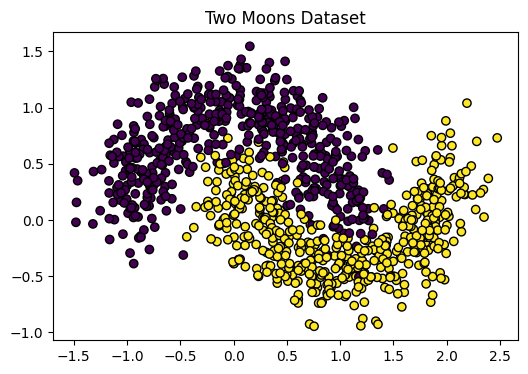

In [9]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# this is unrelated to pcax: we generate and display the training set.
nm_elements = 1024
X, y = make_moons(n_samples=batch_size * (nm_elements // batch_size), noise=0.2, random_state=42)

# Plot the dataset
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Two Moons Dataset")
plt.show()

In [10]:
# we split the dataset in training batches and do the same for the generated test set.
train_dl = list(zip(X.reshape(-1, batch_size, 2), y.reshape(-1, batch_size)))

X_test, y_test = make_moons(n_samples=batch_size * (nm_elements // batch_size) // 2, noise=0.2, random_state=0)
test_dl = tuple(zip(X_test.reshape(-1, batch_size, 2), y_test.reshape(-1, batch_size)))

In [11]:
import random

nm_epochs = 256 // (nm_elements // batch_size)

# Note how the text "Training!" appears only twice. This is because 'train_on_batch' is executed only once,
# and then its compiled equivalent is instead used (which only cares about what happens to jax.Arrays and
# discards all python code). However, since the input structure of the function changes once, the function
# is recompiled, and so the text is printed again. In particular, the structure changes as the `Vodes` are
# not initialised at the beginning, but only after the first forward pass (and thus JAX sees a bunch of `None`
# the first time, while actual tensors fro the second batch, which triggers a recompilation). This can be
# avoided in two ways: perform a dummy forward pass before the training loop:
#
# ```
# with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
#    forward(jax.numpy.zeros((batch_size, 2)), None, model=model)
# ```
# 
# or by cleaning the `Vodes` state before exiting the `train_on_batch` and `eval_on_batch` functions, so that,
# once called again, JAX will see the familiar bunch of `None` values. This can be done by setting 
# `clear_params=pxc.VodeParam | pxc.VodeParam.Cache` when calling `pxu.step` outside of the inference loop.
#
# We recommend the forward pass as it may be helpful to maintain the `Vode` state between batches.

for e in range(nm_epochs):
    random.shuffle(train_dl)
    train(train_dl, T=8, model=model, optim_w=optim_w, optim_h=optim_h)
    a, y = eval(test_dl, model=model)
        
    # We print the average shift of the first vode during the inference steps. Note that it does not depend on
    # the choice for the batch_size (feel free to play around with it, remember to reset the notebook if you
    # you change it). This is because we multiply the learning rate of 'optim_h' by the batch_size. This is 
    # because the total energy is averaged over the batch dimension (as required for the weight updates),
    # so we need to scale the learning rate accordingly for the vode updates.
    print(f"Epoch {e + 1}/{nm_epochs} - Test Accuracy: {a * 100:.2f}%")

Training!
Training!
Epoch 1/8 - Test Accuracy: 90.43%
Epoch 2/8 - Test Accuracy: 95.12%
Epoch 3/8 - Test Accuracy: 96.88%
Epoch 4/8 - Test Accuracy: 96.68%
Epoch 5/8 - Test Accuracy: 96.29%
Epoch 6/8 - Test Accuracy: 96.88%
Epoch 7/8 - Test Accuracy: 96.48%
Epoch 8/8 - Test Accuracy: 96.88%


In [12]:
# pcax.utils contains a couple of useful functions to save and load the parameters of a model.
# They allow to define which subset of the parameters to save, and to load them back into the model.
# The default behaviour is to save all the weights (i.e., values contained in 'pxnn.LayerParam') of
# the model and ignore any 'Vode' value.

import os

# We check what is inside the model.
print(model)

# save/load the model
pxu.save_params(model, "model")
pxu.load_params(model, "model")

# Remove the saved model file
os.remove("model.npz")

(Model):
  .layers[0].nn.weight: LayerParam([32,2], float32)
  .layers[0].nn.bias: LayerParam([32], float32)
  .layers[1].nn.weight: LayerParam([32,32], float32)
  .layers[1].nn.bias: LayerParam([32], float32)
  .layers[2].nn.weight: LayerParam([2,32], float32)
  .layers[2].nn.bias: LayerParam([2], float32)
  .vodes[0].h: VodeParam([32,32], float32)
  .vodes[0].cache: Cache(params=None)
  .vodes[1].h: VodeParam([32,32], float32)
  .vodes[1].cache: Cache(params=None)
  .vodes[2].h: VodeParam([32,2], float32)
  .vodes[2].cache: Cache(params=None)


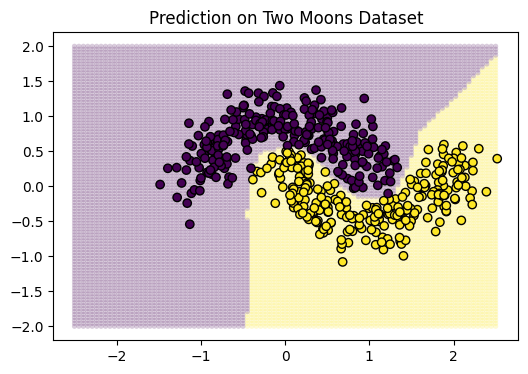

: 

In [13]:
# Here, we evaluate all the grid set as a single batch with 96^2 elements. If we were to directly
# call 'forward' we would get an error as the size of the batch dimension do not agree:
# 'model' contains VodeParams whose batch size is 32 as previously defined, while the function
# input X_grid would have a batch size of 96^2 (this is because we opted to not clear the `Vode`
# state after each batch).
# In order to solve the problem, we first clear all VodeParams (replacing them with None, which
# is ignored by jax) so that jax sees a single size for the batch dimension (i.e., 96^2) and works
# without any problem.

model.clear_params(pxc.VodeParam)

# Test the model on the grid of points in the range [-2.5, 2.5]x[-2.5, 2.5]
X_grid = jax.numpy.stack(np.meshgrid(np.linspace(-2.5, 2.5, 96), np.linspace(-2.0, 2.0, 96))).reshape(2, -1).T
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    y_grid = forward(X_grid, None, model=model).argmax(axis=-1)

plt.figure(figsize=(6, 4))
plt.scatter(X_grid[:, 0], X_grid[:, 1], c=y_grid, cmap='viridis', s=14, marker='o', linewidths=0, alpha=0.2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Prediction on Two Moons Dataset")
plt.show()